In [1]:
import utils
import librosa
import os
import IPython.display as ipd

AUDIO_DIR = os.environ.get('AUDIO_DIR')

filename = utils.get_audio_path(AUDIO_DIR, 2012)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: D:\Masters\CS577\Project\deepMusic-master\fma_small\002\002012.mp3


C:\Users\91903\AppData\Local\Continuum\anaconda3\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Duration: 30.00s, 1323119 samples


In [2]:
import time
import os
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import IPython.display as ipd
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import tensorflow.keras
from tensorflow.keras import models
# from tensorflow.keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier

import utils
import librosa


import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank

def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=4, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(4):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=4, sharex=False,
                             sharey=True, figsize=(20,4))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(4):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=4, sharex=False,
                             sharey=True, figsize=(20,4))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(4):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=4, sharex=False,
                             sharey=True, figsize=(20,4))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(4):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
            

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
AUDIO_DIR = os.environ.get('AUDIO_DIR')
print(AUDIO_DIR)

tracks = utils.load(AUDIO_DIR + '\\fma_metadata\\tracks.csv')
features = utils.load(AUDIO_DIR + '\\fma_metadata\\features.csv')
echonest = utils.load(AUDIO_DIR + '\\fma_metadata\\echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, features.shape, echonest.shape

D:\Masters\CS577\Project\deepMusic-master\fma_small


((106574, 52), (106574, 518), (13129, 249))

In [5]:
subset = tracks.index[tracks['set', 'subset'] == 'small']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

Not enough Echonest features: (13129, 767)


((8000, 52), (8000, 518))

In [6]:
train = tracks[tracks['set', 'split'] == 'training']
val = tracks[tracks['set', 'split'] == 'validation']
test = tracks[tracks['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

# genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
genres = list(tracks['track', 'genre_top'].unique())
print('Top genres ({}): {}'.format(len(genres), genres))
# print(train.loc[99135])
# print(train.loc[99134])

6400 training examples, 800 validation examples, 800 testing examples
Top genres (8): ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']


In [7]:
filename = utils.get_audio_path(AUDIO_DIR, 2012)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: D:\Masters\CS577\Project\deepMusic-master\fma_small\000\000002.mp3


C:\Users\91903\AppData\Local\Continuum\anaconda3\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Duration: 29.98s, 1321967 samples


In [8]:
all_tracks = tracks.copy()
all_tracks.columns = ['_'.join(col).strip() for col in all_tracks.columns.values]
print(all_tracks.columns)

Index(['album_comments', 'album_date_created', 'album_date_released',
       'album_engineer', 'album_favorites', 'album_id', 'album_information',
       'album_listens', 'album_producer', 'album_tags', 'album_title',
       'album_tracks', 'album_type', 'artist_active_year_begin',
       'artist_active_year_end', 'artist_associated_labels', 'artist_bio',
       'artist_comments', 'artist_date_created', 'artist_favorites',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_members', 'artist_name', 'artist_related_projects',
       'artist_tags', 'artist_website', 'artist_wikipedia_page', 'set_split',
       'set_subset', 'track_bit_rate', 'track_comments', 'track_composer',
       'track_date_created', 'track_date_recorded', 'track_duration',
       'track_favorites', 'track_genre_top', 'track_genres',
       'track_genres_all', 'track_information', 'track_interest',
       'track_language_code', 'track_license', 'track_listens',
       'track_

In [9]:
print(all_tracks.shape)

(8000, 52)


In [10]:
classes = list(np.unique(all_tracks['track_genre_top']))
print(classes)
class_dist = all_tracks.groupby(['track_genre_top'])['track_duration'].mean().dropna()
print(class_dist)

['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
track_genre_top
Electronic       251.253
Experimental     238.739
Folk             232.537
Hip-Hop          201.564
Instrumental     205.460
International    252.781
Pop              221.207
Rock             227.191
Name: track_duration, dtype: float64


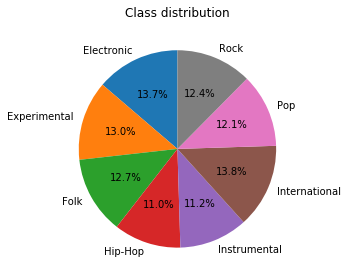

In [11]:
fig, ax = plt.subplots()
ax.set_title('Class distribution', y=1.08)
ax.pie(class_dist,labels=class_dist.index,autopct="%1.1f%%",shadow=False,startangle=90)
ax.axis('equal')
plt.show()
all_tracks.reset_index(inplace=True)

In [12]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d = 1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y,freq)
    

D:\Masters\CS577\Project\deepMusic-master\fma_small
signal -> (1321967,)
rate -> 44100
signal rate -> (44100,)
signal -> (1321967,)
rate -> 44100
signal rate -> (44100,)
signal -> (1321967,)
rate -> 44100
signal rate -> (44100,)
signal -> (1321967,)
rate -> 44100
signal rate -> (44100,)
signal -> (1321967,)
rate -> 44100
signal rate -> (44100,)
signal -> (1323119,)
rate -> 44100
signal rate -> (44100,)
signal -> (1321967,)
rate -> 44100
signal rate -> (44100,)
signal -> (1323119,)
rate -> 44100
signal rate -> (44100,)
44100


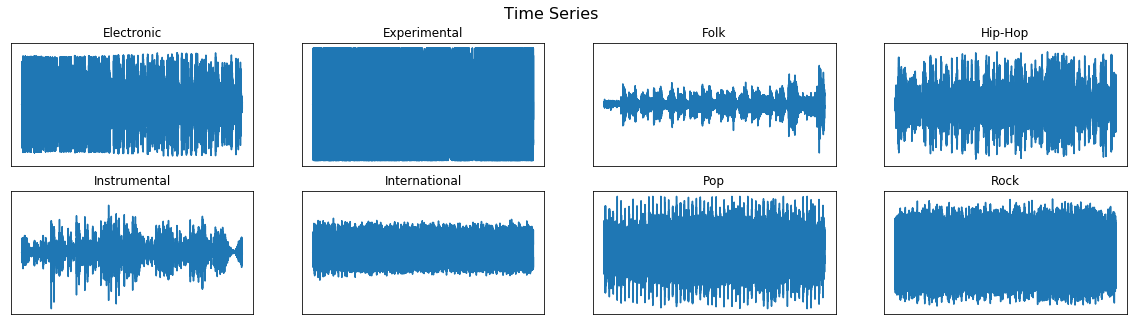

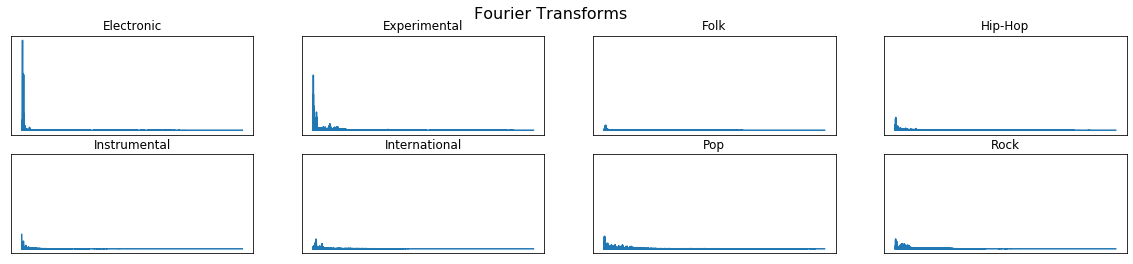

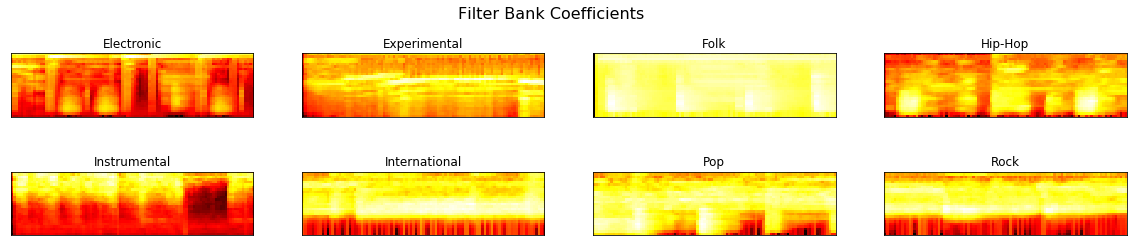

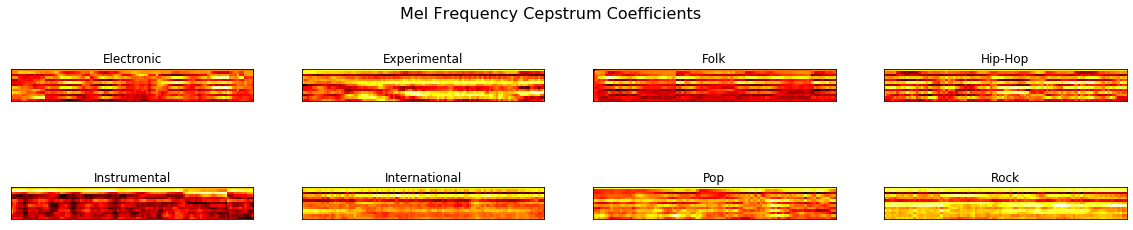

In [13]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10),min_periods=1,center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')
print(AUDIO_DIR)

signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    mp3_file = all_tracks[all_tracks.track_genre_top == c].iloc[0,0]
    signal, rate = utils.FfmpegLoader().load(utils.get_audio_path(AUDIO_DIR, mp3_file))
#     mask = envelope(signal, rate,0.5)
#     signal = signal[mask]
    print(f'signal -> {signal.shape}')
    print(f'rate -> {rate}')
    print(f'signal rate -> {signal[:rate].shape}')
    signals[c] = signal
    fft[c] = calc_fft(signal,rate)
    
    bank = logfbank(signal[:rate],rate,nfilt=26,nfft=1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate],rate,numcep=13, nfilt=26, nfft=1103).T
    mfccs[c] = mel

print(rate)

plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

In [16]:
# CLEANING CORRUPTED FILES
import utils
import librosa
import os
import IPython.display as ipd


subset_small = tracks.index[tracks['set', 'subset'] == 'small']
subset_small = tracks.loc[subset_small]

subset_small.columns = ['_'.join(col).strip() for col in subset_small.columns.values]
print(np.asarray(subset_small.index))
classes = list(np.unique(subset_small['track_genre_top']))
print(classes)
class_dist = subset_small.groupby(['track_genre_top'])['track_duration'].mean().dropna()
print(class_dist)
tids = np.asarray(subset_small.index)

AUDIO_DIR = os.environ.get('AUDIO_DIR')
tids = [2012]
tids = np.asarray(tids)
print(f'tids shape before -> {tids.shape}')
error_tids = []
for tid in tids:
    filename = utils.get_audio_path(AUDIO_DIR, tid)
    try:
        x, sr = librosa.load(filename, sr=None, mono=True)
        print(f'Loaded file {tid}\n')
    except Exception as e:
        print(f'Error loading -> {tid}\n')
        error_tids.append(tid)
        tids = np.delete(tids, np.argwhere(tids==tid))
        continue
print(error_tids)
subset_small.drop(error_tids,inplace = True)
print(f'Deleted in metadata {subset_small.loc[2012]}')
print(f'tids shape after -> {tids.shape}')

    

[     2      5     10 ... 154413 154414 155066]
['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
track_genre_top
Electronic       251.253
Experimental     238.739
Folk             232.537
Hip-Hop          201.564
Instrumental     205.460
International    252.781
Pop              221.207
Rock             227.191
Name: track_duration, dtype: float64
tids shape before -> (1,)
Loaded file 2012

[]
Deleted in metadata album_comments                                                              0
album_date_created                                        2008-11-26 03:23:13
album_date_released                                                       NaT
album_engineer                                                            NaN
album_favorites                                                             0
album_id                                                                  513
album_information                                                 